# TM10007 Assignment template

In [263]:
# Run this to use from colab environment
!git clone https://github.com/Doesjka/TM10007_ML_g9.git

fatal: destination path 'TM10007_ML_g9' already exists and is not an empty directory.


## Import packages

In [264]:
import os
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn import model_selection
from sklearn import decomposition
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform

import seaborn
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import randint


## Define functions

In [265]:
def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        model_selection.learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    print(train_sizes, train_scores, test_scores)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

## Data loading

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [266]:
data = pd.read_csv('/content/TM10007_ML_g9/worclipo/Lipo_radiomicFeatures.csv', index_col=0)
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')


The number of samples: 115
The number of columns: 494


## Splitting data in train and test set


In [267]:
y = data['label']
X = data.drop('label', axis=1)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)


## Handling missing data 
### Throwing out features
All features that exist of at least 50% zeros are deleted from the data. 


In [268]:
zeros = (X_train == 0).sum()
threshold = 0.5 * len(y_train)
print('Threshold = ', threshold)
feature_del = zeros[zeros > threshold]

X_train = X_train.drop(columns=feature_del.index)
print(f'{len(data.columns)-len(X_train.columns)} features were deleted')

Threshold =  43.0
25 features were deleted


In [269]:
more_zeros = (X_train == 0).sum()
columns_zeros = more_zeros[more_zeros > 0].index
print(f'Of the remaining features, {len(columns_zeros)} features have at least one zero')
print(f'There is a total of {more_zeros.sum()} zeros left in the data')

Of the remaining features, 10 features have at least one zero
There is a total of 44 zeros left in the data


### Calculate number of missing values per sample

In [270]:
zeros_r = (X_train == 0).sum(axis=1)
threshold = 0.005 * X_train.size / len(y_train)
print('Threshold = ', threshold)
feature_del = zeros_r[zeros_r > threshold]
print(feature_del)

Threshold =  2.345
ID
Lipo-090_0    5
Lipo-095_0    3
Lipo-076_0    3
Lipo-003_0    3
dtype: int64


In [271]:
aantal_normaal = 0

for column in X_train.columns:
    result = stats.shapiro(X_train[column])
    # print(result.pvalue)
    normaal = result.pvalue > 0.05
    aantal_normaal += normaal
    
print(aantal_normaal, " features zijn normaal verdeeld.")

74  features zijn normaal verdeeld.


/usr/local/lib/python3.9/dist-packages/scipy/stats/_morestats.py:1813: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


### Filling remaining zeros
All remaining zeros are replaced by the mean of that feature. 

In [272]:
X_train_mean = X_train
X_train_median = X_train

for column in columns_zeros[:]:
    print('Kolom: ', column)
    column_mean = X_train.loc[X_train[column]!=0, column].mean()
    column_median = X_train.loc[X_train[column]!=0, column].median()
    print('mean = ', column_mean)
    print('median = ', column_median)

    verschil2_percolumn = column_mean - column_median
    print('Verschil tussen mean en median = ',verschil2_percolumn)

    print('p-waarde normaalverdeling = ', stats.shapiro(X_train.loc[X_train[column]!=0, column]).pvalue)
    print(' ')

    X_train_mean[column].replace(0, column_mean)
    X_train_median[column].replace(0, column_median)


verschil = abs(X_train_mean - X_train_median)
print('Totaal verschil = ', verschil.sum().sum())

# We gaan voor de median
X_train = X_train_median

Kolom:  PREDICT_original_sf_area_min_2.5D
mean =  456.8698899846219
median =  200.39520811289555
Verschil tussen mean en median =  256.4746818717264
p-waarde normaalverdeling =  3.05788068477586e-11
 
Kolom:  PREDICT_original_tf_LBP_quartile_range_R8_P24
mean =  9.301204819277109
median =  11.0
Verschil tussen mean en median =  -1.6987951807228914
p-waarde normaalverdeling =  1.931198130478151e-05
 
Kolom:  PREDICT_original_vf_Frangi_full_quartile_range_SR(1.0, 10.0)_SS2.0
mean =  2.766293780856362e-07
median =  4.602205232532876e-10
Verschil tussen mean en median =  2.7616915756238295e-07
p-waarde normaalverdeling =  9.707482768662333e-20
 
Kolom:  PREDICT_original_vf_Frangi_edge_quartile_range_SR(1.0, 10.0)_SS2.0
mean =  2.766293780856362e-07
median =  4.602205232532876e-10
Verschil tussen mean en median =  2.7616915756238295e-07
p-waarde normaalverdeling =  9.707482768662333e-20
 
Kolom:  PREDICT_original_vf_Frangi_inner_quartile_range_SR(1.0, 10.0)_SS2.0
mean =  8.705055316112096e-

## Outliers eruit halen


In [273]:
Z_score = X_train.apply(stats.zscore)
outliers_per_column = (np.abs(Z_score) > 3).sum()
# outliers_per_row = (np.abs(Z_score) > 3).sum(axis=1)
outliers_total = outliers_per_column.sum()
columns_outliers = outliers_per_column[outliers_per_column > 0].index

print("Het totaal aantal outliers in de data is ", outliers_total)

for column in columns_outliers:
    column_plus_3 = X_train[column].mean() + 3 * X_train[column].std()
    column_min_3 = X_train[column].mean() - 3 * X_train[column].std()

    X_train.loc[Z_score[column] > 3, column] = column_plus_3
    X_train.loc[Z_score[column] < -3, column] = column_min_3

    test2p = (X_train[column] > column_plus_3).sum()
    test2m = (X_train[column] < column_min_3).sum()
    # print(test2p, " en ", test2m)

print("De outliers zijn nu vervangen.")

Het totaal aantal outliers in de data is  601
De outliers zijn nu vervangen.


## Scaling

In [274]:
scaler = preprocessing.StandardScaler().fit(X_train_median)
X_train_scaled = scaler.transform(X_train_median)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_median.columns)

## PCA

In [275]:
pca = decomposition.PCA()
pca.fit(X_train_scaled_df)
X_pca = pca.transform(X_train_scaled_df)

component=0
total_ratio = 0
while total_ratio < 0.95:
    total_ratio += pca.explained_variance_ratio_[component]
    component+=1

X_pca = X_pca[:,0:component]
print(component)

component2=0
while pca.explained_variance_ratio_[component2] > 0.001:
    component2+=1

print(component2)

40
60


## Linear Classification

In [276]:
# Set parameters
parameters = {}

# Specify the cross validation method to use, we use 10-fold stratified cross-validation
cv_10fold = model_selection.StratifiedKFold(n_splits=10)

# Create QDA object
lda = model_selection.GridSearchCV(LinearDiscriminantAnalysis(), parameters, cv=cv_10fold, scoring='accuracy')

# Fit the classifier
lda.fit(X_pca, y_train)

# Whole search
y_pred  = lda.predict(X_pca)

# Show the complete results of the cross validation
lda_df = pd.DataFrame(lda.cv_results_)
display(lda_df)

# Extract the best hyperparameters 
lda.best_params_

# Calculate AUC-score
#if hasattr(lda, 'predict_proba'):
#  y_score = lda.predict_proba(X_pca)[:, 1]
#else:
#  y_score = y_pred
#auc=metrics.roc_auc_score(y_train, y_score)

# Print
#print(f'The AUC is {auc}')
#print('Number of mislabeled points out of a total %d points : %d' % (X_pca.shape[0], (y_train != y_pred).sum()))
#print("\nThe Accuracy of our linear classifier is:", metrics.accuracy_score(y_train, y_pred)*100)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009215,0.00156,0.001691,0.000885,{},0.555556,0.888889,0.333333,0.888889,0.666667,0.333333,0.875,0.5,0.625,0.5,0.616667,0.202244,1


{}

## Quadratic Discriminant Analysis

In [277]:
# set regularization parameter
reg_param=[]
i = 0.0
while i <= 1.0:
    reg_param.append(i) 
    i += 0.1

# set parameters
parameters = {'reg_param': reg_param}

# Specify the cross validation method to use, we use 10-fold stratified cross-validation
cv_10fold = model_selection.StratifiedKFold(n_splits=10)

# Create QDA object
qda = model_selection.RandomizedSearchCV(QuadraticDiscriminantAnalysis(), parameters, n_iter=11,
                                   cv=cv_10fold, scoring='accuracy')

# Fit the model
qda.fit(X_pca, y_train)

# Whole search
y_pred  = qda.predict(X_pca)

# Show the complete results of the cross validation
qda_df = pd.DataFrame(qda.cv_results_)
display(qda_df)

# Extract the best hyperparameters 
qda.best_params_

/usr/local/lib/python3.9/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.9/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.9/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.9/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.9/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.9/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.9/dist-packages/sklearn/discriminan

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg_param,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005290,0.003280,0.002173,0.001626,0.0,{'reg_param': 0.0},0.666667,0.777778,0.444444,0.333333,0.555556,0.555556,0.875,0.250,0.375,0.750,0.558333,0.197281,11
1,0.002668,0.000488,0.000992,0.000131,0.1,{'reg_param': 0.1},0.777778,0.555556,0.666667,0.555556,0.666667,0.666667,0.625,0.375,0.375,0.625,0.588889,0.122537,9
2,0.002920,0.000931,0.001255,0.000477,0.2,{'reg_param': 0.2},0.777778,0.555556,0.666667,0.666667,0.666667,0.666667,0.750,0.375,0.375,0.750,0.625000,0.138332,1
3,0.002372,0.000272,0.000943,0.000123,0.3,{'reg_param': 0.30000000000000004},0.777778,0.666667,0.666667,0.666667,0.666667,0.555556,0.750,0.375,0.375,0.750,0.625000,0.138332,1
4,0.002936,0.001350,0.001101,0.000352,0.4,{'reg_param': 0.4},0.777778,0.666667,0.555556,0.777778,0.666667,0.555556,0.875,0.375,0.375,0.625,0.625000,0.157258,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,0.002816,0.000550,0.001117,0.000227,0.6,{'reg_param': 0.6},0.777778,0.444444,0.555556,0.777778,0.666667,0.555556,0.750,0.500,0.375,0.625,0.602778,0.133968,7
7,0.002806,0.000813,0.001159,0.000376,0.7,{'reg_param': 0.7},0.777778,0.444444,0.555556,0.777778,0.666667,0.555556,0.750,0.625,0.375,0.625,0.615278,0.129554,5
8,0.003122,0.000870,0.001072,0.000177,0.8,{'reg_param': 0.7999999999999999},0.777778,0.444444,0.555556,0.666667,0.777778,0.555556,0.750,0.625,0.375,0.500,0.602778,0.133968,7
9,0.002808,0.000699,0.001315,0.000649,0.9,{'reg_param': 0.8999999999999999},0.777778,0.333333,0.555556,0.666667,0.777778,0.666667,0.750,0.625,0.500,0.500,0.615278,0.136373,5


{'reg_param': 0.2}

## k-NN

{'algorithm': 'kd_tree', 'n_neighbors': 12, 'p': 1, 'weights': 'distance'}
0.6527777777777778
KNeighborsClassifier(n_neighbors=12, p=1, weights='distance')


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/base.py", line 668, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py", line 237, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_base.py", line 810, in kneighbors
    raise ValueError(
ValueError: Expected

[ 7 25 42 59 77] [[nan nan nan nan nan nan nan nan nan nan]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]] [[       nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan]
 [0.55555556 0.44444444 0.55555556 0.44444444 0.44444444 0.44444444
  0.5        0.5        0.375      0.5       ]
 [0.66666667 0.44444444 0.55555556 0.55555556 0.44444444 0.66666667
  0.5        0.625      0.375      0.5       ]
 [0.66666667 0.55555556 0.66666667 0.66666667 0.44444444 0.55555556
  0.75       0.625      0.5        0.625     ]
 [0.55555556 0.33333333 0.55555556 0.66666667 0.77777778 0.88888889
  0.875      0.625      0.75       0.5       ]]


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/dist-packages/matplotlib/pyplot.py'>

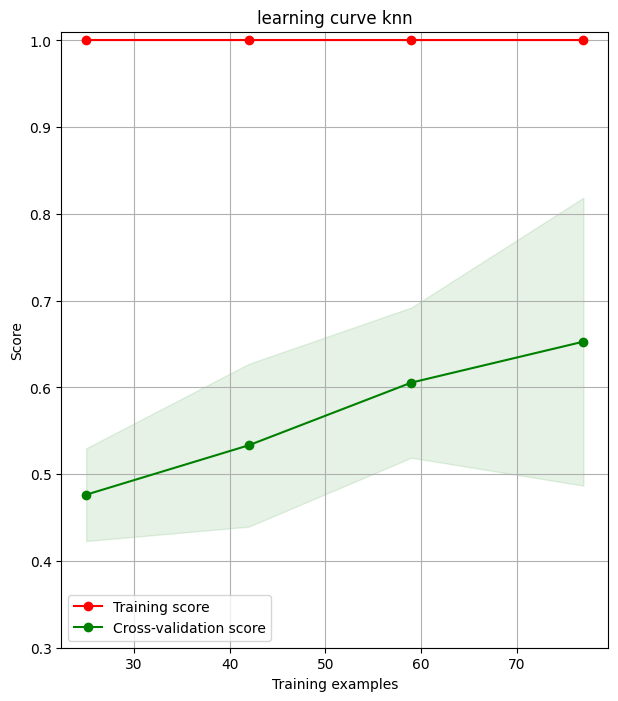

In [278]:
from sklearn import neighbors
# Specify the search range, this could be multiple parameters for more complex classifiers
parameters = {'n_neighbors': randint(1, 50),
              'weights': ['uniform', 'distance'],
              'p': randint(1, 5),
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

# Specify the cross validation method to use, we use 10-fold stratified cross-validation
cv_10fold = model_selection.StratifiedKFold(n_splits=10)

# Create the grid search method, use area under ROC curve as scoring metric
# Too learn more about metrics see: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
clf = model_selection.RandomizedSearchCV(neighbors.KNeighborsClassifier(), parameters, cv=cv_10fold, n_iter=500, scoring='accuracy')

# Do the entire search
clf.fit(X_pca, y_train)

# Show the complete results of the cross validation
clf_df = pd.DataFrame(clf.cv_results_)

# Extract the best k 
clf_df = clf_df.sort_values(by=['rank_test_score'])
optimal_k = clf_df['param_n_neighbors'].iloc[0]
print(clf.best_params_)
print(clf.best_score_)

# Extract the best hyperparameters 
param = clf.best_params_
knn_classifier = neighbors.KNeighborsClassifier(n_neighbors=param['n_neighbors'],p=param['p'],weights=param['weights'])
print(knn_classifier)
knn_classifier.fit(X_train, y_train)

# Make learning curve

# cv = model_selection.ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
# model_selection.LearningCurveDisplay.from_estimator(knn_classifier, X_pca, y_train, train_sizes=[20, 45, 65], cv=cv)

fig = plt.figure(figsize=(24,8))
ax = fig.add_subplot(1, 3, 1)
plot_learning_curve(knn_classifier, 'learning curve knn', X_pca, y_train, ax, ylim=(0.3, 1.01), cv=cv_10fold)


## Random Forest

In [279]:
# Create the random grid
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)

parameters = {'n_estimators': np.arange(10, 400, 10),
              'max_depth': [None, 5, 10, 15],
              'min_samples_split': [2, 5, 10],
              'max_features': [None, 'sqrt', 'log2'],
              'min_samples_leaf': [1, 2, 4]}

cv_10fold = model_selection.StratifiedKFold(n_splits=10)

clf = model_selection.RandomizedSearchCV(RandomForestClassifier(), parameters, cv=cv_10fold, n_iter=50, scoring='accuracy')
    
# Fit the classifier
clf.fit(X_pca, y_train)

# Show the complete results of the cross validation
clf_df = pd.DataFrame(clf.cv_results_)
clf_df = clf_df.sort_values(by=['rank_test_score'])

# Extract the best hyperparameters 
print(clf.best_params_)
print(clf.best_score_)


{'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 15}
0.6944444444444444


## SVM

In [280]:
parameters = {'C': loguniform(0.1, 100),
              'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
              'degree': randint(1, 5),
              'gamma': loguniform(1e-4, 1),
              'class_weight':['balanced', None]}
 
cv_10fold = model_selection.StratifiedKFold(n_splits=10)

clf = model_selection.RandomizedSearchCV(SVC(), parameters, cv=cv_10fold, n_iter=500, scoring='accuracy')

# Do the entire search
clf.fit(X_pca, y_train)

# Show the complete results of the cross validation
clf_df = pd.DataFrame(clf.cv_results_)
clf_df = clf_df.sort_values(by=['rank_test_score'])

# Extract the best hyperparameters 
print(clf.best_score_)
print(clf.best_params_)


0.7222222222222222
{'C': 44.561057573838696, 'class_weight': None, 'degree': 1, 'gamma': 0.00010537409989766666, 'kernel': 'rbf'}
